In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

np.random.seed(0)

In [25]:
d = pd.read_csv("./asos_routine.csv")
d.head()

,station,valid,lon,lat,elevation,tmpf,dwpf,relh,feel,sped,...,mslp,p01m,vsby,gust_mph,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3
0,VTN,2021-11-01 00:52,-100.5489,42.8567,789.24,39.9,24.1,52.88,37.72,3.45,...,1028.4,0.0,10.0,NaN,OVC,NaN,NaN,8000.0,NaN,NaN
1,OMA,2021-11-01 00:52,-95.8992,41.3103,295.67,42.1,27.0,54.78,37.69,6.90,...,1027.2,0.0,10.0,NaN,CLR,NaN,NaN,NaN,NaN,NaN
2,ODX,2021-11-01 00:53,-98.9517,41.6236,628.41,39.9,28.0,62.15,36.65,4.60,...,1028.1,0.0,10.0,NaN,OVC,NaN,NaN,8000.0,NaN,NaN
3,SNY,2021-11-01 00:53,-102.9847,41.1014,1303.84,33.1,30.9,91.51,23.40,13.80,...,1026.0,0.0,9.0,NaN,FEW,OVC,NaN,700.0,1200.0,NaN
4,BFF,2021-11-01 00:53,-103.5956,41.8740,1203.49,34.0,NaN,NaN,NaN,12.65,...,1026.8,NaN,4.0,NaN,BKN,OVC,NaN,700.0,1500.0,NaN


In [26]:
d_filtered = d[d['valid'].str.contains(r'2022-03|2022-04|2022-05')]
d_filtered

,station,valid,lon,lat,elevation,tmpf,dwpf,relh,feel,sped,...,mslp,p01m,vsby,gust_mph,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3
122595,OMA,2022-03-01 00:52,-95.8992,41.3103,295.67,61.0,15.1,16.44,61.00,4.60,...,1015.9,0.0,10.0,NaN,SCT,NaN,NaN,25000.0,NaN,NaN
122596,VTN,2022-03-01 00:52,-100.5489,42.8567,789.24,48.0,21.0,34.05,45.40,5.75,...,1016.8,0.0,10.0,NaN,CLR,NaN,NaN,NaN,NaN,NaN
122597,GRI,2022-03-01 00:53,-98.3096,40.9675,563.46,53.1,8.1,16.03,53.10,9.20,...,1017.8,0.0,10.0,NaN,CLR,NaN,NaN,NaN,NaN,NaN
122598,FNB,2022-03-01 00:53,-95.5920,40.0788,303.69,54.0,10.9,17.58,54.00,6.90,...,1017.3,0.0,10.0,NaN,CLR,NaN,NaN,NaN,NaN,NaN
122599,SNY,2022-03-01 00:53,-102.9847,41.1014,1303.84,51.1,21.0,30.34,51.10,12.65,...,1017.9,0.0,10.0,NaN,CLR,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215455,OFK,2022-05-31 23:56,-97.4351,41.9855,467.52,68.0,51.1,54.70,68.00,16.10,...,1015.6,0.0,10.0,NaN,FEW,NaN,NaN,6000.0,NaN,NaN
215456,OLU,2022-05-31 23:56,-97.3426,41.4480,438.39,72.0,52.0,49.33,72.00,16.10,...,1015.2,0.0,10.0,NaN,SCT,NaN,NaN,5000.0,NaN,NaN
215457,1HW,2022-05-31 23:58,-102.8289,41.3251,1261.68,57.9,45.9,64.23,57.90,16.10,...,1018.6,0.0,10.0,NaN,FEW,NaN,NaN,7000.0,NaN,NaN
215458,1BW,2022-05-31 23:58,-103.9950,41.5117,1602.91,49.6,38.3,64.94,43.85,16.10,...,1020.5,0.0,10.0,NaN,FEW,OVC,NaN,2600.0,3900.0,NaN


In [27]:
d_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92865 entries, 122595 to 215459
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    92865 non-null  object 
 1   valid      92865 non-null  object 
 2   lon        92865 non-null  float64
 3   lat        92865 non-null  float64
 4   elevation  92865 non-null  float64
 5   tmpf       92667 non-null  float64
 6   dwpf       92611 non-null  float64
 7   relh       92602 non-null  float64
 8   feel       92053 non-null  float64
 9   sped       91484 non-null  float64
 10  alti       92699 non-null  float64
 11  mslp       49977 non-null  float64
 12  p01m       90149 non-null  float64
 13  vsby       92610 non-null  float64
 14  gust_mph   33151 non-null  float64
 15  skyc1      92270 non-null  object 
 16  skyc2      12935 non-null  object 
 17  skyc3      4454 non-null   object 
 18  skyl1      39010 non-null  float64
 19  skyl2      12935 non-null  float64
 20  

In [28]:
d_filtered['tmpf'] = pd.to_numeric(d_filtered['tmpf'], errors='coerce')
d_filtered['dwpf'] = pd.to_numeric(d_filtered['dwpf'], errors='coerce')
d_filtered['relh'] = pd.to_numeric(d_filtered['relh'], errors='coerce')
d_filtered['feel'] = pd.to_numeric(d_filtered['feel'], errors='coerce')
d_filtered['sped'] = pd.to_numeric(d_filtered['sped'], errors='coerce')
d_filtered['alti'] = pd.to_numeric(d_filtered['alti'], errors='coerce')
d_filtered['mslp'] = pd.to_numeric(d_filtered['mslp'], errors='coerce')
d_filtered['p01m'] = pd.to_numeric(d_filtered['p01m'], errors='coerce')
d_filtered['vsby'] = pd.to_numeric(d_filtered['vsby'], errors='coerce')
d_filtered.dtypes

C:\Users\Jason\AppData\Local\Temp\ipykernel_30044\1654402992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_filtered['tmpf'] = pd.to_numeric(d_filtered['tmpf'], errors='coerce')
C:\Users\Jason\AppData\Local\Temp\ipykernel_30044\1654402992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_filtered['dwpf'] = pd.to_numeric(d_filtered['dwpf'], errors='coerce')
C:\Users\Jason\AppData\Local\Temp\ipykernel_30044\1654402992.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

station       object
valid         object
lon          float64
lat          float64
elevation    float64
tmpf         float64
dwpf         float64
relh         float64
feel         float64
sped         float64
alti         float64
mslp         float64
p01m         float64
vsby         float64
gust_mph     float64
skyc1         object
skyc2         object
skyc3         object
skyl1        float64
skyl2        float64
skyl3        float64
dtype: object

In [38]:
lengths = d_filtered["valid"].str.len()
lengths.value_counts()

16    92865
Name: valid, dtype: int64

In [40]:
d_filtered['valid']= pd.to_datetime(d_filtered["valid"])
#Creating a column of year
d_filtered['year'] = d_filtered.valid.dt.year

#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature. 
d_filtered['month'] = d_filtered.valid.dt.month

d_filtered['day'] = d_filtered.valid.dt.day

d_filtered.head()

C:\Users\Jason\AppData\Local\Temp\ipykernel_30044\1314548783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_filtered['valid']= pd.to_datetime(d_filtered["valid"])
C:\Users\Jason\AppData\Local\Temp\ipykernel_30044\1314548783.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_filtered['year'] = d_filtered.valid.dt.year
C:\Users\Jason\AppData\Local\Temp\ipykernel_30044\1314548783.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

,station,valid,lon,lat,elevation,tmpf,dwpf,relh,feel,sped,...,gust_mph,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3,year,month,day
122595,OMA,2022-03-01 00:52:00,-95.8992,41.3103,295.67,61.0,15.1,16.44,61.0,4.60,...,NaN,SCT,NaN,NaN,25000.0,NaN,NaN,2022,3,1
122596,VTN,2022-03-01 00:52:00,-100.5489,42.8567,789.24,48.0,21.0,34.05,45.4,5.75,...,NaN,CLR,NaN,NaN,NaN,NaN,NaN,2022,3,1
122597,GRI,2022-03-01 00:53:00,-98.3096,40.9675,563.46,53.1,8.1,16.03,53.1,9.20,...,NaN,CLR,NaN,NaN,NaN,NaN,NaN,2022,3,1
122598,FNB,2022-03-01 00:53:00,-95.5920,40.0788,303.69,54.0,10.9,17.58,54.0,6.90,...,NaN,CLR,NaN,NaN,NaN,NaN,NaN,2022,3,1
122599,SNY,2022-03-01 00:53:00,-102.9847,41.1014,1303.84,51.1,21.0,30.34,51.1,12.65,...,NaN,CLR,NaN,NaN,NaN,NaN,NaN,2022,3,1


In [41]:
s = (d_filtered.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['station', 'skyc1', 'skyc2', 'skyc3']


In [42]:
for i in object_cols:
    print(i, d_filtered[i].isnull().sum())

station 0
skyc1 595
skyc2 79930
skyc3 88411


In [44]:
for i in object_cols:
    d_filtered[i].fillna(d_filtered[i].mode()[0], inplace=True)

C:\Users\Jason\AppData\Local\Temp\ipykernel_30044\2208394026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_filtered[i].fillna(d_filtered[i].mode()[0], inplace=True)
C:\Users\Jason\AppData\Local\Temp\ipykernel_30044\2208394026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_filtered[i].fillna(d_filtered[i].mode()[0], inplace=True)
C:\Users\Jason\AppData\Local\Temp\ipykernel_30044\2208394026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [45]:
t = (d_filtered.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['lon', 'lat', 'elevation', 'tmpf', 'dwpf', 'relh', 'feel', 'sped', 'alti', 'mslp', 'p01m', 'vsby', 'gust_mph', 'skyl1', 'skyl2', 'skyl3']


In [46]:
for i in num_cols:
    print(i, d_filtered[i].isnull().sum())

lon 0
lat 0
elevation 0
tmpf 198
dwpf 254
relh 263
feel 812
sped 1381
alti 166
mslp 42888
p01m 2716
vsby 255
gust_mph 59714
skyl1 53855
skyl2 79930
skyl3 88411


In [57]:
for i in num_cols:
    d_filtered[i].fillna(d_filtered[i].median(), inplace=True)
    
d_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92865 entries, 122595 to 215459
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   station    92865 non-null  object        
 1   valid      92865 non-null  datetime64[ns]
 2   lon        92865 non-null  float64       
 3   lat        92865 non-null  float64       
 4   elevation  92865 non-null  float64       
 5   tmpf       92865 non-null  float64       
 6   dwpf       92865 non-null  float64       
 7   relh       92865 non-null  float64       
 8   feel       92865 non-null  float64       
 9   sped       92865 non-null  float64       
 10  alti       92865 non-null  float64       
 11  mslp       92865 non-null  float64       
 12  p01m       92865 non-null  float64       
 13  vsby       92865 non-null  float64       
 14  gust_mph   92865 non-null  float64       
 15  skyc1      92865 non-null  object        
 16  skyc2      92865 non-null  object 

C:\Users\Jason\AppData\Local\Temp\ipykernel_30044\2092962586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_filtered[i].fillna(d_filtered[i].median(), inplace=True)


In [61]:
d_wo_valid = d_filtered.drop(columns="valid")
d_wo_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92865 entries, 122595 to 215459
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    92865 non-null  object 
 1   lon        92865 non-null  float64
 2   lat        92865 non-null  float64
 3   elevation  92865 non-null  float64
 4   tmpf       92865 non-null  float64
 5   dwpf       92865 non-null  float64
 6   relh       92865 non-null  float64
 7   feel       92865 non-null  float64
 8   sped       92865 non-null  float64
 9   alti       92865 non-null  float64
 10  mslp       92865 non-null  float64
 11  p01m       92865 non-null  float64
 12  vsby       92865 non-null  float64
 13  gust_mph   92865 non-null  float64
 14  skyc1      92865 non-null  object 
 15  skyc2      92865 non-null  object 
 16  skyc3      92865 non-null  object 
 17  skyl1      92865 non-null  float64
 18  skyl2      92865 non-null  float64
 19  skyl3      92865 non-null  float64
 20  

In [60]:
for i in d_wo_valid.columns:
    print(i)

station
lon
lat
elevation
tmpf
dwpf
relh
feel
sped
alti
mslp
p01m
vsby
gust_mph
skyc1
skyc2
skyc3
skyl1
skyl2
skyl3
year
month
day


In [89]:
label_encoder = LabelEncoder()
for i in object_cols:
    d_wo_valid[i] = label_encoder.fit_transform(d_wo_valid[i])
    
d_wo_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92865 entries, 122595 to 215459
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    92865 non-null  int64  
 1   lon        92865 non-null  float64
 2   lat        92865 non-null  float64
 3   elevation  92865 non-null  float64
 4   tmpf       92865 non-null  float64
 5   dwpf       92865 non-null  float64
 6   relh       92865 non-null  float64
 7   feel       92865 non-null  float64
 8   sped       92865 non-null  float64
 9   alti       92865 non-null  float64
 10  mslp       92865 non-null  float64
 11  p01m       92865 non-null  float64
 12  vsby       92865 non-null  float64
 13  gust_mph   92865 non-null  float64
 14  skyc1      92865 non-null  int64  
 15  skyc2      92865 non-null  int64  
 16  skyc3      92865 non-null  int64  
 17  skyl1      92865 non-null  float64
 18  skyl2      92865 non-null  float64
 19  skyl3      92865 non-null  float64
 20  

In [110]:
d_wo_valid

,station,lon,lat,elevation,tmpf,dwpf,relh,feel,sped,alti,...,gust_mph,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3,year,month,day
122595,36,-95.8992,41.3103,295.67,61.0,15.1,16.44,61.00,4.60,29.99,...,27.6,4,2,2,25000.0,5000.0,6000.0,2022,3,1
122596,42,-100.5489,42.8567,789.24,48.0,21.0,34.05,45.40,5.75,29.97,...,27.6,1,2,2,4000.0,5000.0,6000.0,2022,3,1
122597,17,-98.3096,40.9675,563.46,53.1,8.1,16.03,53.10,9.20,30.01,...,27.6,1,2,2,4000.0,5000.0,6000.0,2022,3,1
122598,16,-95.5920,40.0788,303.69,54.0,10.9,17.58,54.00,6.90,30.03,...,27.6,1,2,2,4000.0,5000.0,6000.0,2022,3,1
122599,39,-102.9847,41.1014,1303.84,51.1,21.0,30.34,51.10,12.65,30.07,...,27.6,1,2,2,4000.0,5000.0,6000.0,2022,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215455,33,-97.4351,41.9855,467.52,68.0,51.1,54.70,68.00,16.10,30.01,...,27.6,2,2,2,6000.0,5000.0,6000.0,2022,5,31
215456,35,-97.3426,41.4480,438.39,72.0,52.0,49.33,72.00,16.10,29.99,...,27.6,4,2,2,5000.0,5000.0,6000.0,2022,5,31
215457,2,-102.8289,41.3251,1261.68,57.9,45.9,64.23,57.90,16.10,30.11,...,27.6,2,2,2,7000.0,5000.0,6000.0,2022,5,31
215458,0,-103.9950,41.5117,1602.91,49.6,38.3,64.94,43.85,16.10,30.18,...,27.6,2,2,2,2600.0,3900.0,6000.0,2022,5,31


In [97]:
def countmax(series):
      return series.value_counts().argmax()

In [104]:
# Prepairing attributes of scale data
# Group by station, month, date -> daily precipitation

    
grouped = d_wo_valid.groupby(['station', 'year', 'month', 'day']).agg({'lon':'mean', 'lat':'mean', 'elevation':'mean', 'tmpf':'mean',
                                                               'dwpf':'mean', 'relh':'mean', 'feel':'mean',
                                                               'alti':'mean', 'mslp':'mean', 'p01m':'sum',
                                                               'vsby':'mean', 'skyc1':countmax, 'skyc2':countmax,
                                                               'skyc3':countmax, 'skyl1':'mean', 'skyl2':'mean',
                                                               'skyl3':'mean'}).reset_index()
grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3902 entries, 0 to 3901
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    3902 non-null   int64  
 1   year       3902 non-null   int64  
 2   month      3902 non-null   int64  
 3   day        3902 non-null   int64  
 4   lon        3902 non-null   float64
 5   lat        3902 non-null   float64
 6   elevation  3902 non-null   float64
 7   tmpf       3902 non-null   float64
 8   dwpf       3902 non-null   float64
 9   relh       3902 non-null   float64
 10  feel       3902 non-null   float64
 11  alti       3902 non-null   float64
 12  mslp       3902 non-null   float64
 13  p01m       3902 non-null   float64
 14  vsby       3902 non-null   float64
 15  skyc1      3902 non-null   int64  
 16  skyc2      3902 non-null   int64  
 17  skyc3      3902 non-null   int64  
 18  skyl1      3902 non-null   float64
 19  skyl2      3902 non-null   float64
 20  skyl3   

In [102]:
grouped

,station,year,month,day,lon,lat,elevation,tmpf,dwpf,relh,...,alti,mslp,p01m,vsby,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3
0,0,2022,3,1,-103.9950,41.5117,1602.91,48.316667,22.262500,36.060833,...,30.122917,1018.375000,0.00,10.000000,0,0,0,5500.000000,5791.666667,6000.000000
1,0,2022,3,2,-103.9950,41.5117,1602.91,50.082609,27.417391,43.750000,...,30.148696,1018.413043,0.00,10.000000,0,0,0,10478.260870,6391.304348,6000.000000
2,0,2022,3,3,-103.9950,41.5117,1602.91,51.925000,22.116667,33.442500,...,30.068750,1015.212500,0.00,10.000000,0,0,0,6666.666667,5791.666667,6000.000000
3,0,2022,3,4,-103.9950,41.5117,1602.91,45.725000,23.545833,48.088333,...,29.807500,1007.333333,0.00,9.916667,0,0,0,13583.333333,5812.500000,6000.000000
4,0,2022,3,5,-103.9950,41.5117,1602.91,25.508333,21.150000,84.572500,...,29.751667,1009.058333,0.50,3.860000,0,0,0,2275.000000,3920.833333,5204.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,42,2022,5,27,-100.5489,42.8567,789.24,69.520833,43.987500,47.298750,...,29.891667,1010.770833,0.00,10.000000,0,0,0,4333.333333,5000.000000,6000.000000
3898,42,2022,5,28,-100.5489,42.8567,789.24,74.925000,48.495833,43.676667,...,29.637917,1001.304167,0.00,10.000000,0,0,0,4333.333333,5000.000000,6000.000000
3899,42,2022,5,29,-100.5489,42.8567,789.24,68.750000,52.558333,59.046250,...,29.441667,994.895833,0.00,10.000000,0,0,0,4683.333333,5000.000000,6000.000000
3900,42,2022,5,30,-100.5489,42.8567,789.24,62.062500,54.854167,78.314583,...,29.425417,994.950000,25.66,8.020833,0,0,0,3333.333333,5029.166667,6775.000000


In [120]:
grouped['p01m_tmrw'] = grouped['p01m']

grouped["p01m_tmrw"] = np.where(grouped["p01m_tmrw"] >= 1, 1, 0)
grouped["p01m"] = np.where(grouped["p01m"] >= 1, 1, 0)

grouped

,station,year,month,day,lon,lat,elevation,tmpf,dwpf,relh,...,mslp,p01m,vsby,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3,p01m_tmrw
0,0,2022,3,1,-103.9950,41.5117,1602.91,48.316667,22.262500,36.060833,...,1018.375000,0,10.000000,0,0,0,5500.000000,5791.666667,6000.000000,0
1,0,2022,3,2,-103.9950,41.5117,1602.91,50.082609,27.417391,43.750000,...,1018.413043,0,10.000000,0,0,0,10478.260870,6391.304348,6000.000000,0
2,0,2022,3,3,-103.9950,41.5117,1602.91,51.925000,22.116667,33.442500,...,1015.212500,0,10.000000,0,0,0,6666.666667,5791.666667,6000.000000,0
3,0,2022,3,4,-103.9950,41.5117,1602.91,45.725000,23.545833,48.088333,...,1007.333333,0,9.916667,0,0,0,13583.333333,5812.500000,6000.000000,0
4,0,2022,3,5,-103.9950,41.5117,1602.91,25.508333,21.150000,84.572500,...,1009.058333,0,3.860000,0,0,0,2275.000000,3920.833333,5204.166667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,42,2022,5,27,-100.5489,42.8567,789.24,69.520833,43.987500,47.298750,...,1010.770833,0,10.000000,0,0,0,4333.333333,5000.000000,6000.000000,0
3898,42,2022,5,28,-100.5489,42.8567,789.24,74.925000,48.495833,43.676667,...,1001.304167,0,10.000000,0,0,0,4333.333333,5000.000000,6000.000000,0
3899,42,2022,5,29,-100.5489,42.8567,789.24,68.750000,52.558333,59.046250,...,994.895833,0,10.000000,0,0,0,4683.333333,5000.000000,6000.000000,0
3900,42,2022,5,30,-100.5489,42.8567,789.24,62.062500,54.854167,78.314583,...,994.950000,1,8.020833,0,0,0,3333.333333,5029.166667,6775.000000,1


In [121]:
features = grouped.drop(['station', 'lon', 'lat', 'p01m_tmrw','year', 'day', 'month'], axis=1) # dropping target and extra columns       
target = d['p01m_tmrw']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

,count,mean,std,min,25%,50%,75%,max
elevation,3902.0,-8.506778e-16,1.000128,-1.146624,-0.864889,-0.249341,0.799622,2.505650
tmpf,3902.0,-6.177358e-16,1.000128,-3.478656,-0.599064,-0.074131,0.640576,2.551648
dwpf,3902.0,-3.108169e-16,1.000128,-2.632439,-0.712336,-0.147454,0.744698,2.794268
relh,3902.0,1.850561e-16,1.000128,-2.265378,-0.737794,-0.080260,0.643916,2.875054
feel,3902.0,-1.150057e-16,1.000128,-3.245445,-0.606901,-0.028238,0.705561,2.496451
alti,3902.0,2.214857e-14,1.000128,-2.703733,-0.534117,0.096940,0.658886,1.984391
mslp,3902.0,1.741958e-14,1.000128,-3.611331,-0.075955,0.074610,0.146819,2.711034
p01m,3902.0,2.276213e-16,1.000128,-0.440457,-0.440457,-0.440457,-0.440457,2.270369
vsby,3902.0,-2.110292e-15,1.000128,-7.608517,0.098580,0.451408,0.451408,0.451408
skyc1,3902.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


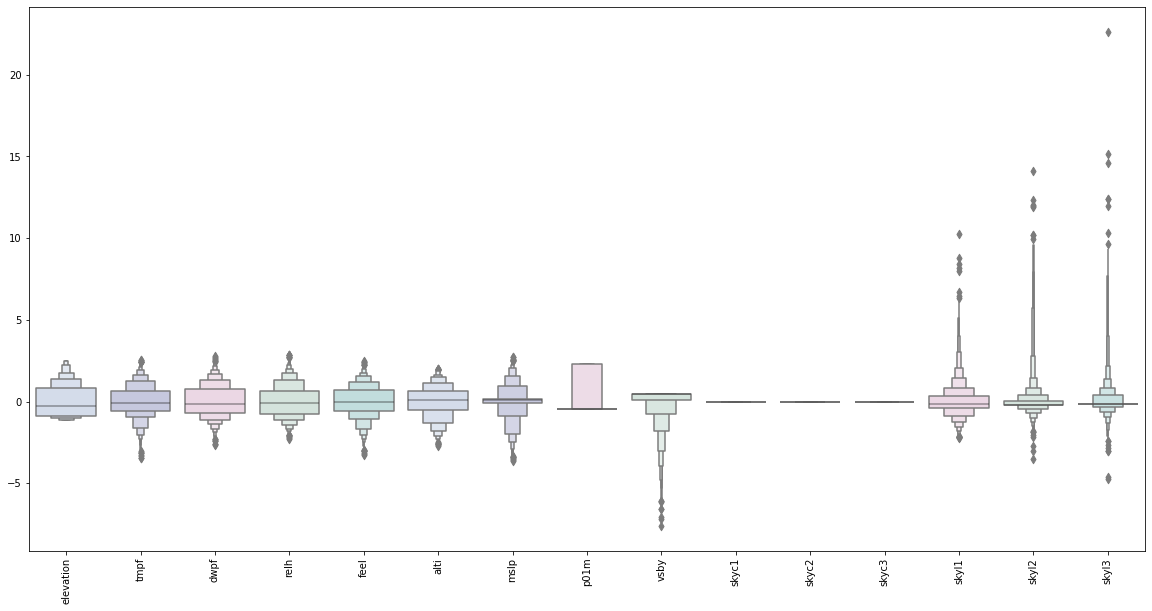

In [122]:
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [127]:
features

,elevation,tmpf,dwpf,relh,feel,alti,mslp,p01m,vsby,skyc1,skyc2,skyc3,skyl1,skyl2,skyl3,p01m_tmrw
0,2.505650,-0.038031,-0.665469,-1.393548,-0.133343,0.964405,0.807974,-0.440457,0.451408,0.0,0.0,0.0,0.514188,0.604264,-0.144276,0.0
1,2.505650,0.087895,-0.305326,-0.880216,0.046545,1.082360,0.814209,-0.440457,0.451408,0.0,0.0,0.0,3.197385,1.213858,-0.144276,0.0
2,2.505650,0.219273,-0.675657,-1.568349,0.216185,0.716558,0.289703,-0.440457,0.451408,0.0,0.0,0.0,1.143001,0.604264,-0.144276,0.0
3,2.505650,-0.222838,-0.575810,-0.590588,-0.266348,-0.478828,-1.001538,-0.440457,0.363201,0.0,0.0,0.0,4.870965,0.625444,-0.144276,0.0
4,2.505650,-1.664454,-0.743193,1.845108,-1.897169,-0.734301,-0.718844,-0.440457,-6.047692,0.0,0.0,0.0,-1.224031,-1.297629,-2.245946,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,0.232352,1.474002,0.852333,-0.643300,1.325106,-0.093712,-0.438199,-0.440457,0.451408,0.0,0.0,0.0,-0.114625,-0.200546,-0.144276,0.0
3898,0.232352,1.859364,1.167304,-0.885112,1.677400,-1.254780,-1.989599,-0.440457,0.451408,0.0,0.0,0.0,-0.114625,-0.200546,-0.144276,0.0
3899,0.232352,1.419035,1.451128,0.140967,1.372483,-2.152750,-3.039799,-0.440457,0.451408,0.0,0.0,0.0,0.074019,-0.200546,-0.144276,0.0
3900,0.232352,0.942161,1.611524,1.427328,0.988830,-2.227104,-3.030922,2.270369,-1.643511,0.0,0.0,0.0,-0.653608,-0.170895,1.902377,0.0


In [128]:
#full data for 
features["p01m_tmrw"] = target

#Dropping with outlier
features = features[(features["vsby"]<-5)]
features = features[(features["skyl1"]<5)]
features = features[(features["skyl2"]<5)&(features["skyl2"]>-3)]
features = features[(features["skyl3"]<5)&(features["skyl3"]>-3)]

features.shape

(22, 16)

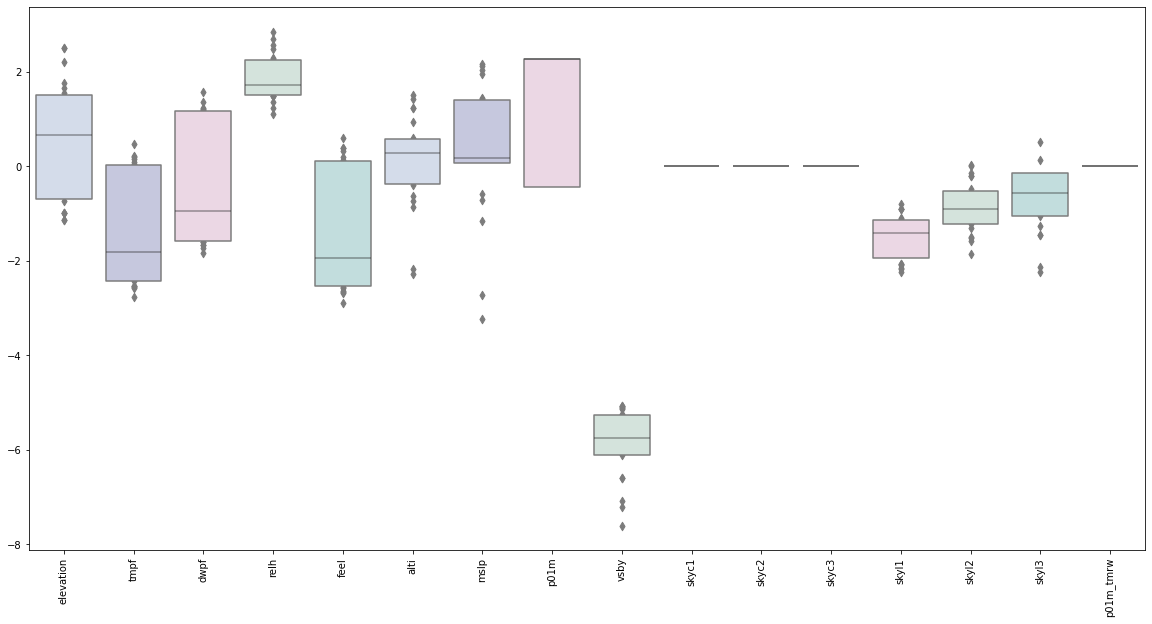

In [129]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [132]:
X = features.drop(["p01m_tmrw"], axis=1)
y = features["p01m_tmrw"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(22, 15)

In [133]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
1/1 [==============================] - 1s 889ms/step - loss: 0.6931 - accuracy: 0.4615 - val_loss: 0.6931 - val_accuracy: 1.0000
Epoch 2/150
1/1 [==============================] - 0s 30ms/step - loss: 0.6931 - accuracy: 1.0000 - val_loss: 0.6931 - val_accuracy: 1.0000
Epoch 3/150
1/1 [==============================] - 0s 26ms/step - loss: 0.6931 - accuracy: 1.0000 - val_loss: 0.6930 - val_accuracy: 1.0000
Epoch 4/150
1/1 [==============================] - 0s 26ms/step - loss: 0.6930 - accuracy: 1.0000 - val_loss: 0.6930 - val_accuracy: 1.0000
Epoch 5/150
1/1 [==============================] - 0s 28ms/step - loss: 0.6930 - accuracy: 1.0000 - val_loss: 0.6929 - val_accuracy: 1.0000
Epoch 6/150
1/1 [==============================] - 0s 28ms/step - loss: 0.6929 - accuracy: 1.0000 - val_loss: 0.6929 - val_accuracy: 1.0000
Epoch 7/150
1/1 [==============================] - 0s 28ms/step - loss: 0.6929 - accuracy: 1.0000 - val_loss: 0.6928 - val_accuracy: 1.0000
Epoch 8/150
1/1 [==

1/1 [==============================] - 0s 28ms/step - loss: 0.6902 - accuracy: 1.0000 - val_loss: 0.6901 - val_accuracy: 1.0000
Epoch 60/150
1/1 [==============================] - 0s 26ms/step - loss: 0.6900 - accuracy: 1.0000 - val_loss: 0.6900 - val_accuracy: 1.0000
Epoch 61/150
1/1 [==============================] - 0s 24ms/step - loss: 0.6900 - accuracy: 1.0000 - val_loss: 0.6900 - val_accuracy: 1.0000
Epoch 62/150
1/1 [==============================] - 0s 25ms/step - loss: 0.6899 - accuracy: 1.0000 - val_loss: 0.6899 - val_accuracy: 1.0000
Epoch 63/150
1/1 [==============================] - 0s 24ms/step - loss: 0.6898 - accuracy: 1.0000 - val_loss: 0.6898 - val_accuracy: 1.0000
Epoch 64/150
1/1 [==============================] - 0s 25ms/step - loss: 0.6898 - accuracy: 1.0000 - val_loss: 0.6898 - val_accuracy: 1.0000
Epoch 65/150
1/1 [==============================] - 0s 24ms/step - loss: 0.6898 - accuracy: 1.0000 - val_loss: 0.6897 - val_accuracy: 1.0000
Epoch 66/150
1/1 [========

1/1 [==============================] - 0s 27ms/step - loss: 0.6866 - accuracy: 1.0000 - val_loss: 0.6865 - val_accuracy: 1.0000
Epoch 118/150
1/1 [==============================] - 0s 26ms/step - loss: 0.6867 - accuracy: 1.0000 - val_loss: 0.6865 - val_accuracy: 1.0000
Epoch 119/150
1/1 [==============================] - 0s 26ms/step - loss: 0.6866 - accuracy: 1.0000 - val_loss: 0.6864 - val_accuracy: 1.0000
Epoch 120/150
1/1 [==============================] - 0s 27ms/step - loss: 0.6865 - accuracy: 1.0000 - val_loss: 0.6863 - val_accuracy: 1.0000
Epoch 121/150
1/1 [==============================] - 0s 28ms/step - loss: 0.6865 - accuracy: 1.0000 - val_loss: 0.6863 - val_accuracy: 1.0000
Epoch 122/150
1/1 [==============================] - 0s 27ms/step - loss: 0.6860 - accuracy: 1.0000 - val_loss: 0.6862 - val_accuracy: 1.0000
Epoch 123/150
1/1 [==============================] - 0s 26ms/step - loss: 0.6862 - accuracy: 1.0000 - val_loss: 0.6861 - val_accuracy: 1.0000
Epoch 124/150
1/1 [=

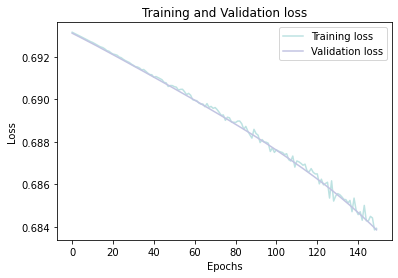

In [134]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

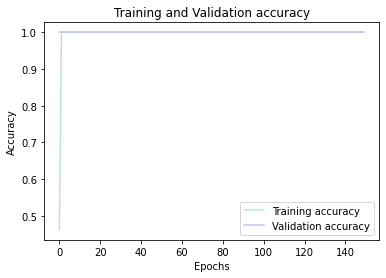

In [135]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()